In [1]:
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt

import nltk
nltk.data.path.append("nltk_data")

/Users/Sensei/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## EDA

In [51]:
train = pd.read_csv("A1/train.csv", header=None)
test = pd.read_csv("A1/sample_input.csv", header=None)

In [52]:
train.head(20)

,0,1
0,"Definitely runs long, wore 4.5 inch heels and ...",5
1,I think it's a little big/long in the torso.,5
2,This dress is amazing! It has a built in like...,5
3,"didn't even need a bra and I am a 34DD, was so...",5
4,I wore this to my birthday dinner and loved it...,4
5,It fit perfect i have (VSsizeD) boobs and i wo...,5
6,"The material is a bit heavy, but it was fine f...",5
7,This gown was nice. It was a dress to glam up ...,3
8,It's actually a 18/20w which is why I say it r...,5
9,The dress is very comfortable with plenty of r...,4


In [53]:
train[0].isna().sum(), train[1].isna().sum()

(44, 0)

In [54]:
train = train.dropna()

In [55]:
train[1].unique()

array([5, 4, 3, 2, 1])

(array([  749.,     0.,  1984.,     0.,     0.,  7473.,     0., 37249.,
            0., 87205.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

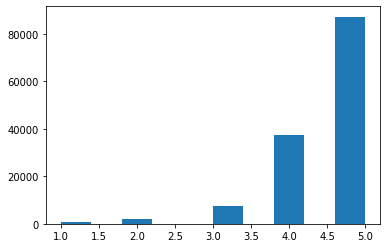

In [56]:
plt.hist(train[1])

In [57]:
train.loc[60485][0]

"I could've worn the 6, but it was a bit tight around the bust. The 8 was a little roomy around my waist and hips, but much more comfortable. The color is beautiful! I recommend a statement necklace to add some sparkle and a bit of interest to the neckline."

I can't find this dataset anywhere. Has it been artificially super-upsampled?

In [58]:
train.count()

0    134660
1    134660
dtype: int64

In [59]:
len(train[0].unique())

133800

Okay, something seems off. Get everything which starts with the same prompt

In [60]:
train.loc[2][0]

"This dress is amazing!  It has a built in like corset so it holds you in in all the right places!  It also plumps you up in your chest!  The fabric is comfortable and looks just like the picture.  I wore this dress to a Mardi Gras ball and got more compliments on it than any other dress I have ever worn.  The tan lining makes the dress look sexy without being too provocative ! I usually wear an 8L but I chose the 6L as it fit a little better.  The length was perfect as I am 5'10 and wore 2' heals. I would buy this dress!"

In [61]:
stw_1 = train.loc[train[0].str.lower().str.startswith("loved this dress so much")]
print(len(stw_1))
stw_1.head()

47


,0,1
15,Loved this dress so much. Color was beautiful....,3
5152,Loved this dress so much that I ended up purch...,5
11609,Loved this dress SO much. While I've loved a ...,5
12291,Loved this dress so much. My husband wanted me...,5
12691,Loved this dress so much I wanted to keep it! ...,5


In [62]:
stw_2 = train.loc[train[0].str.lower().str.startswith("this dress is amazing")]
print(len(stw_2))
stw_2.head()

272


,0,1
2,This dress is amazing! It has a built in like...,5
77,This dress is amazing! I was a bit unsure how ...,5
101,This dress is amazing. Runs small so I had to ...,5
373,This dress is amazing. Fit so well and made me...,5
933,This dress is amazing- it is fitted at the bus...,5


that's a lot of matches... Hypothesis is that the dataset is auto-generated.

let's look at some negative reviews and see if there's a pattern

In [63]:
train.loc[(train[1] == 1) | (train[1] == 1)]

,0,1
292,Awkward fit for someone who has a small chest.,1
679,"So I ordered this dress for dinner, but it was...",1
856,If you have supple boobs first off--Congrats!!...,1
867,The fabric would be great for a cool evening.,1
900,Even though I had an XS the romper was really ...,1
...,...,...
133815,The arms were way toooo small! I just knew I w...,1
133850,I ordered the XS ans Small for backup-- both w...,1
133874,"I am 5'7'', and this dress was very long and c...",1
133938,There is a big piece of fabric that drapes dow...,1


In [100]:
train.loc[train[0].str.lower().str.startswith('i am')]

,0,1,2,3,4,5,6,7,8
12264,I am typically a 4 on top and 6 on bottom. I h...,4,"[I, am, typically, a, 4, on, top, and, 6, on, ...","[(I, PRP), (am, VBP), (typically, RB), (a, DT)...","[(POS, i, PRP), (POS, am, VBP), (POS, typicall...","[(POS, typically, RB), (POS, 4, CD), (POS, top...","[(POS, typically, RB), (POS, 4, CD), (POS, top...","[(POS, typically, RB), (POS, 4, CD), (POS, top...","[POS_typically_RB, POS_4_CD, POS_top_NN, POS_6..."
29384,I am so in love with this dress that I've alre...,5,"[I, am, so, in, love, with, this, dress, that,...","[(I, PRP), (am, VBP), (so, RB), (in, IN), (lov...","[(POS, i, PRP), (POS, am, VBP), (POS, so, RB),...","[(POS, love, NN), (POS, dress, NN), (POS, 've,...","[(POS, love, NN), (POS, dress, NN), (POS, 've,...","[(POS, love, NN), (POS, dress, NN), (POS, 've,...","[POS_love_NN, POS_dress_NN, POS_'ve_VBP, POS_a..."
15643,I am a B cup and couldn't fill it out. I ended...,4,"[I, am, a, B, cup, and, could, n't, fill, it, ...","[(I, PRP), (am, VBP), (a, DT), (B, NNP), (cup,...","[(POS, i, PRP), (POS, am, VBP), (POS, a, DT), ...","[(POS, b, NNP), (POS, cup, NN), (POS, could, M...","[(POS, b, NNP), (POS, cup, NN), (POS, could, M...","[(POS, b, NNP), (POS, cup, NN), (POS, could, M...","[POS_b_NNP, POS_cup_NN, POS_could_MD, POS_n't_..."
1338,"I am 5""4' and didn't like the way this looked....",2,"[I, am, 5, '', 4, ', and, did, n't, like, the,...","[(I, PRP), (am, VBP), (5, CD), ('', ''), (4, C...","[(POS, i, PRP), (POS, am, VBP), (POS, 5, CD), ...","[(POS, 5, CD), (POS, '', ''), (POS, 4, CD), (P...","[(POS, 5, CD), (POS, '', ''), (POS, 4, CD), (P...","[(POS, 5, CD), (POS, '', ''), (POS, 4, CD), (P...","[POS_5_CD, POS_''_'', POS_4_CD, POS_'_POS, POS..."
19064,"I am normally a 6/8 and a medium, but this was...",5,"[I, am, normally, a, 6/8, and, a, medium, ,, b...","[(I, PRP), (am, VBP), (normally, RB), (a, DT),...","[(POS, i, PRP), (POS, am, VBP), (POS, normally...","[(POS, normally, RB), (POS, 6/8, CD), (POS, me...","[(POS, normally, RB), (POS, 6/8, CD), (POS, me...","[(POS, normally, RB), (POS, 6/8, CD), (POS, me...","[POS_normally_RB, POS_6/8_CD, POS_medium_NN, P..."
...,...,...,...,...,...,...,...,...,...
8155,"I am usually a Medium (or 6), but I wore this ...",4,"[I, am, usually, a, Medium, (, or, 6, ), ,, bu...","[(I, PRP), (am, VBP), (usually, RB), (a, DT), ...","[(POS, i, PRP), (POS, am, VBP), (POS, usually,...","[(POS, usually, RB), (POS, medium, NN), (POS, ...","[(POS, usually, RB), (POS, medium, NN), (POS, ...","[(POS, usually, RB), (POS, medium, NN), (POS, ...","[POS_usually_RB, POS_medium_NN, POS_(_(, POS_6..."
6546,I am a size 14 in jeans. I am 5'4 and 225lbs. ...,3,"[I, am, a, size, 14, in, jeans, ., I, am, 5, '...","[(I, PRP), (am, VBP), (a, DT), (size, NN), (14...","[(POS, i, PRP), (POS, am, VBP), (POS, a, DT), ...","[(POS, size, NN), (POS, 14, CD), (POS, jeans, ...","[(POS, size, NN), (POS, 14, CD), (POS, jean, N...","[(POS, size, NN), (POS, 14, CD), (POS, jean, N...","[POS_size_NN, POS_14_CD, POS_jean_NNS, POS_._...."
17043,"I am 5'8"" the regular length on this dress was...",4,"[I, am, 5, ', 8, '', the, regular, length, on,...","[(I, PRP), (am, VBP), (5, CD), (', POS), (8, C...","[(POS, i, PRP), (POS, am, VBP), (POS, 5, CD), ...","[(POS, 5, CD), (POS, ', POS), (POS, 8, CD), (P...","[(POS, 5, CD), (POS, ', POS), (POS, 8, CD), (P...","[(POS, 5, CD), (POS, ', POS), (POS, 8, CD), (P...","[POS_5_CD, POS_'_POS, POS_8_CD, POS_''_'', POS..."
26370,I am 5'1 and 130lb. I ordered the small and a...,5,"[I, am, 5, ', 1, and, 130lb, ., I, ordered, th...","[(I, PRP), (am, VBP), (5, CD), (', POS), (1, C...","[(POS, i, PRP), (POS, am, VBP), (POS, 5, CD), ...","[(POS, 5, CD), (POS, ', POS), (POS, 1, CD), (P...","[(POS, 5, CD), (POS, ', POS), (POS, 1, CD), (P...","[(POS, 5, CD), (POS, ', POS), (POS, 1, CD), (P...","[POS_5_CD, POS_'_POS, POS_1_CD, POS_130lb_CD, ..."


In [65]:
train.loc[train[0].str.lower().str.startswith('this is')]

,0,1
10,"This is a gorgeous dress that was PERFECT, exc...",4
198,This is a very pretty dress. The back is sexy ...,5
289,"This is an incredibly flattering, well made dr...",5
313,"This is a great top, very stylish but somewhat...",4
432,"This is a no fuss, easy to wear, beautiful dre...",5
...,...,...
134442,This is a great dress! The fabric color and te...,4
134476,This is a great top and you could even size do...,5
134483,This is a very causal and comfortable top! I l...,5
134493,This is probably because of my short/petit fra...,3


In [66]:
train.loc[train[0].str.lower().str.startswith('it fit') & (train[1] == 3)]

,0,1
349,"It fit well in the bust area, but was too tigh...",3
2474,it fit true to size,3
5253,It fits very large in the waist. I normally we...,3
5929,It fit everywhere except my hips. It was a bi...,3
11273,"It fit well. Under the arm, it was a little sc...",3
22411,it fit fine,3
26579,"It fit like a glove, but the front skirt porti...",3
31110,It fit perfectly!,3
38161,It fit true to size and was very comfortable f...,3
45637,It fit but it felt like a straight jacket. It...,3


More notes:
- There are a lot of height values. Parsing them would be important? I don't know.

Let's do one more metric: number of exclamation marks (!) predicts sentiment (likelihood weigh this)

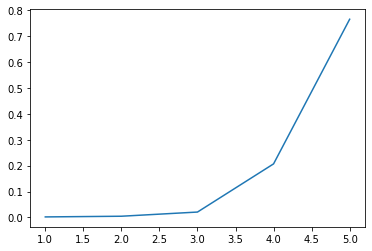

In [67]:
excl_cnt = train[0].str.count('!')
tot_excl_cnts = sum(excl_cnt)
excl_cnts = []
for i in range(1,6):
    n_excl_cnts = sum(excl_cnt.loc[train[1] == i])
    n_cnts = len(train.loc[train[1] == 1])
    norm_excl_cnts = (n_excl_cnts/tot_excl_cnts)*(n_cnts/len(train))
    excl_cnts.append(norm_excl_cnts)

# normalize excl_cnts to 1
s = sum(excl_cnts)
excl_cnts = [i/s for i in excl_cnts]
plt.plot(range(1,6), excl_cnts)

In [68]:
excl_cnts

[0.0019011723896402782,
 0.004536130613878558,
 0.020696095925820925,
 0.2069359438320298,
 0.7659306572386305]

very strong correlation with seeing an exclamation mark and it being a positive review.

In [69]:
# from collections import Counter
# from imblearn.combine import SMOTEENN
# from imblearn.over_sampling import RandomOverSampler
# 
# ros = RandomOverSampler(random_state=42)
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = ros.fit_resample(df[0].to_numpy().reshape(-1,1), df[1])
# 
# print(sorted(Counter(y_resampled).items()))

## Downsampling

so that my laptop doesn't spontaneously combust

In [70]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy={1: 749, 2: 1984, 3: 5000, 4: 10000, 5:15000})
X, y = rus.fit_resample(train[0].to_numpy().reshape(-1,1), train[1])
train = pd.DataFrame({0: X.flatten(), 1: y})
train

,0,1
0,I couldn't wear this dress it would not zip up...,1
1,i got this one and a green one and enved up we...,1
2,I received this item for a date. I was unable ...,1
3,Beware if you are bustier. This is not friendl...,1
4,Too big . Thicker material than expected. Not ...,1
...,...,...
32728,"I used to wear a 10, but I lost some weight, s...",5
32729,Loved this dress!! It was VERY short but it di...,5
32730,"I wore this dress for a ""cocktail"" type charit...",5
32731,I wore this on NYE. I ordered two dresses and ...,5


(array([  749.,     0.,  1984.,     0.,     0.,  5000.,     0., 10000.,
            0., 15000.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

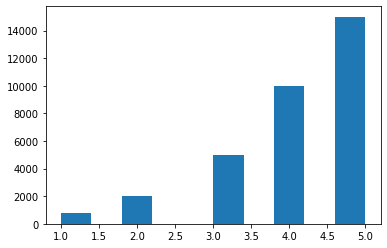

In [71]:
plt.hist(train[1])

## Splits

In [72]:
from sklearn.model_selection import train_test_split

X, y = train[0], train[1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.DataFrame({0: X_train, 1: y_train}) # reindexing?
val = pd.DataFrame({0: X_val, 1: y_val})
len(train), len(val)

(26186, 6547)

(array([ 133.,    0.,  379.,    0.,    0., 1004.,    0., 2050.,    0.,
        2981.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

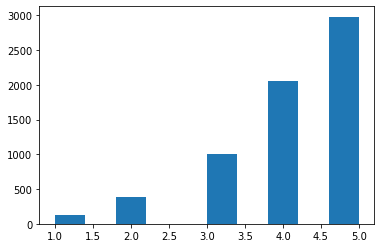

In [73]:
plt.hist(val[1])

## Feature Extraction

Tokenize -> POS tag -> negate -> stopword removal -> Stemming -> bigram + trigram extraction -> tf-idf -> tSNE embedding

In [75]:
# tokenize
from nltk.tokenize import word_tokenize
train[2] = train[0].apply(word_tokenize)
val[2] = val[0].apply(word_tokenize)
train

,0,1,2
7569,Fit was exactly as described. Some of the dres...,3,"[Fit, was, exactly, as, described, ., Some, of..."
6350,It was too small for me so I had to return it....,3,"[It, was, too, small, for, me, so, I, had, to,..."
15922,I got compliments on this dress all night long...,4,"[I, got, compliments, on, this, dress, all, ni..."
31220,This dress is so comfortable. The neckline was...,5,"[This, dress, is, so, comfortable, ., The, nec..."
12264,I am typically a 4 on top and 6 on bottom. I h...,4,"[I, am, typically, a, 4, on, top, and, 6, on, ..."
...,...,...,...
29802,"IN LOVE WITH THIS DRESS! It was form-fitting, ...",5,"[IN, LOVE, WITH, THIS, DRESS, !, It, was, form..."
5390,I wore the dress for a rehearsal dinner in Cal...,3,"[I, wore, the, dress, for, a, rehearsal, dinne..."
860,Beautiful soft fabric. Did not flatter my body...,2,"[Beautiful, soft, fabric, ., Did, not, flatter..."
15795,This dress runs small for sure. I read it in t...,4,"[This, dress, runs, small, for, sure, ., I, re..."


In [76]:
# POS tag
import nltk
train[3] = train[2].apply(nltk.pos_tag)
val[3] = val[2].apply(nltk.pos_tag)


In [77]:
# negation via looking at PoS: negate all adjectives/verbs from a not/n't to the next stopword/punctuation mark
# also do lower case
def negate(pos_arr):
    neg_pos_arr = []
    negating = False
    for word in pos_arr:
        w = word[0].lower()
        if (w == 'not' or w == "n't"):
            negating = True
            neg_pos_arr.append(("POS", w, word[1]))
            continue
        elif (word[1] == '.' or word[1] == ':' or word[1] == 'IN' or word[1] == 'CC'):
            negating = False
            neg_pos_arr.append(("POS", w, word[1]))
            continue
        
        if negating and (word[1].startswith("VB") or word[1].startswith("JJ")):
            neg_pos_arr.append(("NEG", w, word[1]))
        else:
            neg_pos_arr.append(("POS", w, word[1]))
    
    return neg_pos_arr
        
train[4] = train[3].apply(negate)
val[4] = val[3].apply(negate)

In [129]:
# stopword and punctuation removal
# we should also remove irrelevant parts of speech (DT, PRP, etc)
from nltk.corpus import stopwords 
import re

sw = set(stopwords.words('english'))

def stopword_removal(pos_arr):
    char_regex = re.compile(r"[A-Z]+")
    word_arr = []
    for word in pos_arr:
        if (word[1] not in sw) and (word[2].isalpha() or word[1] == '!'):
            word_arr.append(word)
    return word_arr

train[5] = train[4].apply(stopword_removal)
val[5] = val[4].apply(stopword_removal)

In [132]:
# lemmatization
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

def lemmatize(pos_arr):
    
    # POS tag conversion
    pos_tag_map = {
        'J': 'a', # adjective
        'N': 'n', # noun
        'V': 'v', # verb
        'R': 'r'  # adverb
    }
    lemmatized_list = []
    for word in pos_arr:
        if word[2][0] in pos_tag_map:
            lemmatized_list.append((word[0], wnl.lemmatize(word[1], pos=pos_tag_map[word[2][0]]), word[2]))
        else:
            lemmatized_list.append(word)
    return lemmatized_list

train[6] = train[5].apply(lemmatize)
val[6] = val[5].apply(lemmatize)

In [133]:
# bigram/trigram extraction

import re

def create_ngram_extractor(ngram_pos_pattern_maps):
    
    def extract_ngrams(pos_arr):
        ngrams = []
        
        for pattern in ngram_pos_pattern_maps:
            for i in range(len(pos_arr)-len(pattern)):
                fit = True
                toks = []
                for j in range(len(pattern)):
                    if not pattern[j].match(pos_arr[i+j][2]):
                        fit = False
                        break
                    else:
                        toks.append(pos_arr[i+j][1])
                if fit:
                    ngrams.append(("POS", "-".join(toks) ,f"{len(pattern)}GRAM"))
        
        return pos_arr + ngrams
        
    return extract_ngrams

# just an example
ngram_conf = [
    [re.compile(r"[A-Z]*"), re.compile(r"[A-Z]*")], # all bigrams (not containing punctuation)
#     [re.compile(r"VBP"), re.compile(r"P")],
    [re.compile(r"[A-Z]*"), re.compile(r"[A-Z]*"), re.compile(r"[A-Z]*")] # all trigrams (not containing punctuation)
#    [re.compile(r"VB*"), re.compile(r"JJ*")]
]

train[7] = train[6].apply(create_ngram_extractor(ngram_conf))
val[7] = val[6].apply(create_ngram_extractor(ngram_conf))

In [134]:
# concatenate to final string features
def create_str_features(pos_tokens):
    features = []
    for tok in pos_tokens:
        features.append(f"{tok[0]}_{tok[1]}_{tok[2]}")
    return features

train[8] = train[7].apply(create_str_features)
val[8] = val[7].apply(create_str_features)

In [135]:
# tf-idf vectorization of final features
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None
)

train_features = tfidf.fit_transform(list(train[8]))
val_features = tfidf.transform(list(val[8]))
train_features

<26186x792385 sparse matrix of type '<class 'numpy.float64'>'
	with 2151110 stored elements in Compressed Sparse Row format>

## Models

In [146]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
train_decomp = svd.fit_transform(train_features)
val_decomp = svd.transform(val_features)

### SVM

In [147]:
from sklearn.svm import SVC
svc = SVC(probability=False)
svc.fit(train_decomp, train[1])

SVC()

In [148]:
from sklearn.metrics import accuracy_score
accuracy_score(svc.predict(train_decomp), train[1])

0.7173680592683113

Not too bad :)

In [149]:
svc_val_preds = svc.predict(val_decomp)
accuracy_score(svc.predict(val_decomp), val[1])

0.5758362608828471

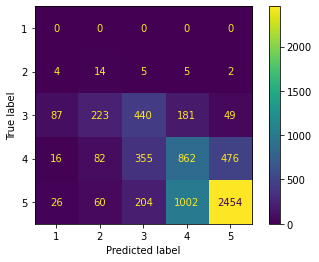

In [150]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(svc_val_preds, val[1])

LMAO what now. This is clearly terrible at judging negative reviews

In [152]:
from sklearn.metrics import f1_score

f1_micro = f1_score(svc_val_preds, val[1], average='micro') 
f1_macro = f1_score(svc_val_preds, val[1], average='macro')
(f1_micro+f1_macro)/2

0.4569627942582661

In [153]:
f1_micro

0.5758362608828471

In [154]:
f1_macro

0.33808932763368504

### XGBoost

In [87]:
from xgboost import XGBClassifier

In [98]:
clf = XGBClassifier(
    max_depth=8,
    n_estimators=100
)
clf.fit(train_decomp, train[1]-1)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [99]:
xgb_preds = clf.predict(val_decomp)
accuracy_score(val[1]-1, xgb_preds)

0.5420803421414389

In [145]:
f1_micro = f1_score(xgb_preds, val[1]-1, average='micro') 
f1_macro = f1_score(xgb_preds, val[1]-1, average='macro')
(f1_micro+f1_macro)/2

0.4390741131035896

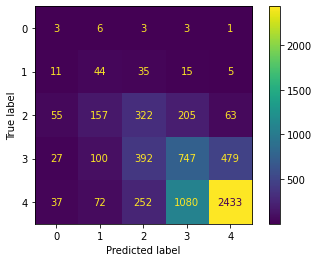

In [142]:
ConfusionMatrixDisplay.from_predictions(xgb_preds, val[1]-1)

Same phenomena here. Pretty sure F1 will be terrible

### Naive Bhais

In [39]:
train_nb_ds = [({j: w for j, w in enumerate(row[2])}, row[1]) for i, row in train.iterrows()]
val_nb_ds = [({j: w for j, w in enumerate(row[2])}, row[1]) for i, row in val.iterrows()]

In [40]:
nb_clf = nltk.NaiveBayesClassifier.train(train_nb_ds)

In [41]:
nltk.classify.accuracy(nb_clf, val_nb_ds)

0.35339906590555265